<a href="https://colab.research.google.com/github/hieubkset/Colab-Notebooks/blob/master/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Phân loại văn bản**

Một cách xây dựng model khác để giải bài toán phân loại văn bản trên tập dữ liệu [IMDB dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb).

Mục tiêu:

+ Hiểu thêm về API của [TensorFlow datasets](https://www.tensorflow.org/datasets).
+ Học cách vẽ learning curve.

## Tóm tắt

Ở bài trước [TF03: Phân loại văn bản I](https://ezcodin.com/tf03), chúng ta đã build một model phân loại các review phim trong tập dữ liệu **IMDB** dataset bằng cách sử dụng pre-trained model như input layer để chuyển đổi đầu vào từ text sang embedding vector. Trong bài này, chúng ta sẽ tìm hiểu một cách khác để xử lý dữ liệu đầu vào.

## **Chương trình**

### **1. Khai báo các thư viện**

In [0]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE" )

Version:  2.1.0
Hub version:  0.7.0
GPU is available


### **2. Chuẩn bị data**

Ở các bài trước, chúng ta đã học cách load data từ **Tensorflow Datasets** như sau:

```python
train_data, validation_data, test_data = tfds.load(
    name='imdb_reviews',
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True
)
```

Cách này trả về cho chúng ta dữ liệu thô dưới dạng text. 

Trong bài này, chúng ta sẽ sử dụng một option khác để lấy dữ liệu đã được mã hóa.

In [0]:
(train_data, validation_data, test_data), info = tfds.load(
    name='imdb_reviews/subwords8k',
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True,
    with_info=True
)

Thay vì '**imdb_reviews**', chúng ta sử dụng '**imdb_reviews/subwords8k**'. Cách này trả về cho chúng ta dữ liệu đã được encode (mã hóa) dưới dạng số tự nhiên. Cụ thể, mỗi từ sẽ được gán với một số tự nhiên. Chúng ta sẽ thực hiện explore data để xem định dạng dữ liệu.

**Từ `info` chúng ta lấy được `encoder`**:

In [0]:
encoder = info.features['text'].encoder
print('Vocabulary size: ', encoder.vocab_size)

Vocabulary size:  8185


**Sử dụng `encoder` để encode và decode**:

In [0]:
sample_string = 'Hello Tensorflow'

encoded_string = encoder.encode(sample_string)
print('Encoded string is: ', encoded_string)

original_string = encoder.decode(encoded_string)
print('The original string: ', original_string)

assert original_string == sample_string

Encoded string is:  [4025, 222, 6307, 2327, 2934]
The original string:  Hello Tensorflow


**Thử xem một example và một label**

In [0]:
for train_example, train_label in train_data.take(1):
    print('Encoded text: ', train_example.numpy())
    print('Lable: ', train_label.numpy())

Encoded text:  [  62   18   41  604  927   65    3  644 7968   21   35 5096   36   11
   43 2948 5240  102   50  681 7862 1244    3 3266   29  122  640    2
   26   14  279  438   35   79  349  384   11 1991    3  492   79  122
  188  117   33 4047 4531   14   65 7968    8 1819 3947    3   62   27
    9   41  577 5044 2629 2552 7193 7961 3642    3   19  107 3903  225
   85  198   72    1 1512  738 2347  102 6245    8   85  308   79 6936
 7961   23 4981 8044    3 6429 7961 1141 1335 1848 4848   55 3601 4217
 8050    2    5   59 3831 1484 8040 7974  174 5773   22 5240  102   18
  247   26    4 3903 1612 3902  291   11    4   27   13   18 4092 4008
 7961    6  119  213 2774    3   12  258 2306   13   91   29  171   52
  229    2 1245 5790  995 7968    8   52 2948 5240 8039 7968    8   74
 1249    3   12  117 2438 1369  192   39 7975]
Lable:  0


**Tạo batch:**

*Note: Vì kích thước bộ nhớ có hạn nên ta không load toàn bộ data vào CPU hay GPU. Thay vào đó, chúng ta chỉ load một phần của data. Quá trình này gọi là tạo batch, cụ thể là ta sẽ chỉ định mỗi lần sẽ load bao nhiêu dữ liệu vào. Con số này thường là lũy thừa của 2 như: 8, 16 hay 32. Đối với training data, chúng ta còn thực hiện xáo trộn data (shuffle) để tránh overfitting.*

In [0]:
BUFFER_SIZE = 1000
train_batches = train_data.shuffle(BUFFER_SIZE).padded_batch(32, padded_shapes=([None], []))
validation_batches = validation_data.padded_batch(32, padded_shapes=([None], []))
test_batches = test_data.padded_batch(32, padded_shapes=([None], []))

Quá trình tạo batch yêu cầu các dữ liệu trong cùng một batch có cùng shape. Trong trường hợp này, yêu cầu có cùng length vì dữ liệu chỉ có 1 chiều. Ta sử dụng padded_batch để thực hiện zero-pad (thêm 0) sao cho tất cả dữ liệu có cùng length.

### **3. Build model**

Ở bài trước, chúng ta sẽ sử dụng một *pre-trained text embedding model* để chuyển đầu vào từ text sang embedding vector.

```python
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
```


Trong bài này, chúng ta sẽ tìm hiểu cách xây dựng layer để học embedding vector. 

In [0]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(encoder.vocab_size, 16))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


Trong quá trình training, **Embedding** layer sẽ học cách encode mỗi số tự nhiên (đại diện cho một từ) thành một embedding vector có 16 chiều. Đầu ra của nó sẽ có shape là (batch_size, length, 16). Các example trong cùng một batch sẽ có cùng *length* do ta đã thực hiện *padded_batch*. Tuy nhiên, các batch khác nhau sẽ có *length* khác nhau. **GlobalAveragePooling1D** sẽ đảm bảo rằng đầu ra của nó sẽ luôn có shape là (batch_size, 16). Nó loại bỏ vấn đề khác *length* giữa các batch. 



### **4. Khai báo Optimizer và Loss function**
Adam Optimizer và Binary Crossentropy loss.

In [0]:
model.compile(optimizer='adam', 
              loss= tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

### **5. Tiến hành training**

Thực hiện training trong 20 epoch. Trong quá trình training, các thông số như loss và accuracy trên tập validation sẽ được lưu lại.


In [0]:
history = model.fit(train_batches,
                    epochs=20,
                    validation_data=validation_batches,
                    validation_steps=30)

Epoch 1/20
469/469 [==============================] - 7s 14ms/step - loss: 0.6884 - accuracy: 0.5007 - val_loss: 0.6782 - val_accuracy: 0.5188
Epoch 2/20
469/469 [==============================] - 5s 11ms/step - loss: 0.6623 - accuracy: 0.5089 - val_loss: 0.6381 - val_accuracy: 0.5469
Epoch 3/20
469/469 [==============================] - 5s 11ms/step - loss: 0.6139 - accuracy: 0.5662 - val_loss: 0.5880 - val_accuracy: 0.6125
Epoch 4/20
469/469 [==============================] - 5s 11ms/step - loss: 0.5613 - accuracy: 0.6329 - val_loss: 0.5411 - val_accuracy: 0.6542
Epoch 5/20
469/469 [==============================] - 5s 11ms/step - loss: 0.5122 - accuracy: 0.7027 - val_loss: 0.5015 - val_accuracy: 0.7000
Epoch 6/20
469/469 [==============================] - 5s 11ms/step - loss: 0.4717 - accuracy: 0.7513 - val_loss: 0.4685 - val_accuracy: 0.7625
Epoch 7/20
469/469 [==============================] - 5s 11ms/step - loss: 0.4355 - accuracy: 0.7880 - val_loss: 0.4413 - val_accuracy: 0.7604

**6. Testing**

In [0]:
loss, accuracy = model.evaluate(test_batches, verbose=0)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

Loss:  0.33074653916575414
Accuracy:  0.8458


Với 20 epoch, model cho accuracy trên tập test khoảng 85%. Với cách tiếp cận nâng cao hơn, accuracy có thể lên tới 95%.

### **7. Vẽ learning curve**


In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [0]:
epochs = range(20)
train_loss = history_dict['loss']
validation_loss = history_dict['val_loss']
train_accuracy = history_dict['accuracy']
validation_accuracy = history_dict['val_accuracy']

In [0]:
import matplotlib.pyplot as plt

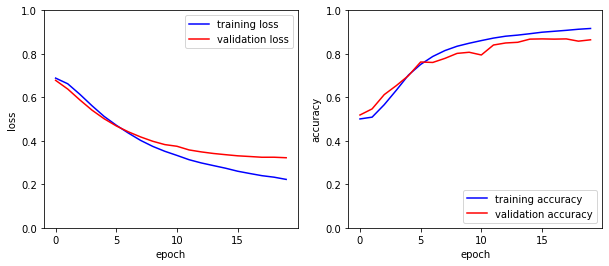

In [0]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='training loss')
plt.plot(epochs, validation_loss, 'r-', label='validation loss')
plt.ylim([0, 1])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b-', label='training accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='validation accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()

Nhìn vào đồ thị trên ta có thể thấy, sau khoảng 10 epoch training loss vẫn tiếp tục giảm, tuy nhiên validation loss đã bão hòa. Việc tiếp tục training sau 10 epoch không giúp cải thiện accuracy thay vào đó dẫn tới overfitting.